## Tile analysis & Figure

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from scipy.stats import pearsonr
import cv2
import torch
import pandas as pd
import json
from sklearn.metrics import f1_score
import numpy as np
from pathlib import Path
import albumentations as A

from tqdm import tqdm

import sys
sys.path.append("../")
from src.dataset import get_width_height, get_augmentations, NormalizationLayer, TileSlideDataset, get_effective_width_height,\
        TileImg2ImgSlideDataset, get_input_mean_std
from src.generators import get_generator
from src.metrics import CellMetrics

In [2]:
checkpoint_dir = "/root/workdir/checkpoints_paper/vitmatte_hotpimus_lora"
#checkpoint_dir = "/root/workdir/checkpoints_paper/vitmatte_hotpimus_lora"

checkpoint_path = str(Path(checkpoint_dir) / "model.weights.ckpt")
config_path = str(Path(checkpoint_dir) / "config.yaml")

In [6]:
cfg = OmegaConf.load(config_path)

In [7]:
test_cell_dataframe = pd.read_csv(str(Path(checkpoint_dir) / "test_dataframe_cell.csv"))

In [10]:
test_dataframe = pd.read_csv(cfg.data.test_dataframe_path)

width, height = get_width_height(test_dataframe)
width, height = get_effective_width_height(width, height, train=True)

spatial_augmentations = A.Compose([
    A.CenterCrop(width=256, height=256),
], additional_targets={"image_target": "image", "nuclei": "image"})

with open("../channel_stats.json", "r") as f:
    channel_stats = json.load(f)

channel_stats_rgb = get_input_mean_std(cfg, channel_stats["RGB"])
preprocess_input_fn = NormalizationLayer(channel_stats_rgb, mode="he")

dataset = TileImg2ImgSlideDataset(
        dataframe=test_dataframe, preprocess_input_fn=preprocess_input_fn,
        spatial_augmentations=spatial_augmentations, return_nuclei=True)

num_workers = 6
batch_size = 16
device = "cpu"
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, pin_memory=device!="cpu",
    shuffle=False, drop_last=False, num_workers=num_workers
)

he [[123.675 116.28  103.53 ]] [[58.395 57.12  57.375]]


In [53]:
from timm.layers import resample_abs_pos_embed

def resize_pos_embed_statedict(state_dict, model, img_size, vit_key):
    if img_size != 224:
        old_pos_embed = state_dict[vit_key + '.pos_embed']
        pos_embed = resample_abs_pos_embed(
            old_pos_embed,
            new_size=model.patch_embed.grid_size,
            num_prefix_tokens=0 if model.no_embed_class \
                else model.num_prefix_tokens,
        )
        state_dict[vit_key +'.pos_embed'] = pos_embed
    return state_dict

def get_generator_state_dict(state_dict):
    generator_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("generator."):
            generator_state_dict[k.replace("generator.", "")] = v
    return generator_state_dict

In [54]:
torch.cuda.empty_cache()


nc_out = len(cfg.data.targ_channel_names)
nc_in = 3
generator = get_generator(cfg.model.model_name, width, nc_in, nc_out, cfg).eval()

state_dict = torch.load(checkpoint_path, map_location="cpu")["state_dict"]
logreg_state_dict = {k.replace("logreg_layer.", ""): v for k, v in state_dict.items() if "logreg_layer." in k}
state_dict = get_generator_state_dict(state_dict)
if hasattr(generator, "encoder"):
    if hasattr(generator.encoder, "vit"):
        state_dict = resize_pos_embed_statedict(
            state_dict, generator.encoder.vit, width, "encoder.vit")
    elif hasattr(generator.encoder, "model"):
        if hasattr(generator.encoder.model, "pos_embed"):
            state_dict = resize_pos_embed_statedict(
                state_dict, generator.encoder.model, width, "encoder.model")

generator.load_state_dict(state_dict)

generator = generator.eval().cuda().half()

In [11]:
tile_names = []
cell_ids = []
for batch in tqdm(dataloader):
    nuclei_masks = batch["nuclei"].float()
    tile_names_batch = batch["tile_name"]
    for idx_batch in range(len(nuclei_masks)):
        nuclei_mask_b = nuclei_masks[idx_batch]
        tile_name_b = tile_names_batch[idx_batch]
        tile_names.append(tile_name_b)
        cell_idxs_b = torch.unique(nuclei_mask_b[nuclei_mask_b>0]).to(torch.uint32)
        cell_ids.append(cell_idxs_b.numpy())


100%|██████████| 685/685 [00:37<00:00, 18.32it/s]


In [12]:
df_tiles_map = pd.DataFrame(columns=["tile_name", "cell_ids"])
df_tiles_map["tile_name"] = tile_names
df_tiles_map["cell_ids"] = cell_ids
df_tiles_map["tile_name"] = df_tiles_map["tile_name"].astype("category")
df_tiles_map.head()

,tile_name,cell_ids
0,19510_C11_US_SCAN_OR_001__151039-registered.om...,"[323086, 323436, 323514, 323595, 323623, 32362..."
1,19510_C11_US_SCAN_OR_001__151039-registered.om...,"[335611, 336201, 336240, 336296, 336329, 33638..."
2,19510_C11_US_SCAN_OR_001__151039-registered.om...,"[372757, 372897, 374234, 374295, 375200, 37575..."
3,19510_C11_US_SCAN_OR_001__151039-registered.om...,"[384139, 384450, 384633, 384706, 384760, 38504..."
4,19510_C11_US_SCAN_OR_001__151039-registered.om...,"[440281, 440370, 440549, 440757, 440789, 44085..."


In [13]:
tile_exploded = df_tiles_map.explode('cell_ids').rename(columns={'cell_ids': 'cell_id'})
test_cell_dataframe = test_cell_dataframe.merge(tile_exploded, on='cell_id', how='left')
del tile_exploded
test_cell_dataframe.head()

,cell_id,CD31_pred,CD45_pred,CD68_pred,CD4_pred,FOXP3_pred,CD8a_pred,CD45RO_pred,CD20_pred,PD-L1_pred,...,CD45RO_pos,CD20_pos,PD-L1_pos,CD3e_pos,CD163_pos,E-cadherin_pos,Ki67_pos,Pan-CK_pos,SMA_pos,tile_name
0,12,0.035714,0.473214,0.098214,0.183036,0.013393,0.183036,0.093750,0.013393,0.102679,...,False,False,False,True,False,False,False,False,False,19510_C11_US_SCAN_OR_001__151039-registered.om...
1,18,0.106742,0.741573,0.019663,0.379213,0.075843,0.286517,0.216292,0.084270,0.132022,...,False,True,False,False,False,False,False,False,False,19510_C11_US_SCAN_OR_001__151039-registered.om...
2,23,0.090909,0.612440,0.095694,0.320574,0.014354,0.234450,0.177034,0.038278,0.157895,...,False,False,False,False,False,False,False,False,False,19510_C11_US_SCAN_OR_001__151039-registered.om...
3,27,0.187500,1.916667,0.250000,1.083333,0.020833,0.791667,0.250000,0.166667,0.041667,...,False,False,False,False,False,False,False,False,False,19510_C11_US_SCAN_OR_001__151039-registered.om...
4,29,0.048387,0.854839,0.141129,0.354839,0.033266,0.187500,0.107863,0.128024,0.066532,...,False,False,False,False,False,False,False,False,False,19510_C11_US_SCAN_OR_001__151039-registered.om...


In [28]:
pred_mean_cols = [col for col in test_cell_dataframe.columns if "_pred" in col]
target_cols = [col for col in test_cell_dataframe.columns if "_pos" in col]
pred_cols = [col + "_logreg" for col in pred_mean_cols]
n_marker = len(pred_mean_cols)

logreg = torch.nn.Linear(n_marker, n_marker)
logreg_state_dict = torch.load(str(Path(checkpoint_dir) / "logreg.pth"), map_location="cpu")
logreg.load_state_dict(logreg_state_dict)
logreg.eval()

with torch.inference_mode():
    cell_probs = torch.sigmoid(logreg(torch.from_numpy(test_cell_dataframe[pred_mean_cols].values).float())).numpy()
    cell_preds = cell_probs > 0.5

test_cell_dataframe[pred_cols] = cell_preds

In [ ]:
def compute_f1_score_groupby(row, marker_name):
    marker_name_pred = marker_name.replace("_pos", "_pred_logreg")
    if len(row) == 0:
        return 1
    elif (row[marker_name].sum() == 0) & (row[marker_name_pred].sum() == 0):
        return 1
    elif (~(row[marker_name].sum()) == 0) & (~(row[marker_name_pred].sum()) == 0):
        return 1
    else:
        return f1_score(row[marker_name], row[marker_name_pred])

tile_sums = test_cell_dataframe.groupby("tile_name")[pred_cols].sum().reset_index(drop=False)
tile_sums = tile_sums.merge(test_cell_dataframe.groupby("tile_name")[target_cols].sum().reset_index(drop=False), on="tile_name")
for col in target_cols:
    tile_sums[f"{col}_f1"] = test_cell_dataframe.groupby("tile_name").apply(
        lambda group: compute_f1_score_groupby(group, col), include_groups=True).values

/tmp/ipykernel_16128/3730870536.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tile_sums = test_cell_dataframe.groupby("tile_name")[pred_cols].sum().reset_index(drop=False)


/tmp/ipykernel_16128/3730870536.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tile_sums[f"{col}_f1"] = test_cell_dataframe.groupby("tile_name").apply(
/tmp/ipykernel_16128/3730870536.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tile_sums[f"{col}_f1"] = test_cell_dataframe.groupby("tile_name").apply(
/tmp/ipykernel_16128/3730870536.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

0.9773175722822249


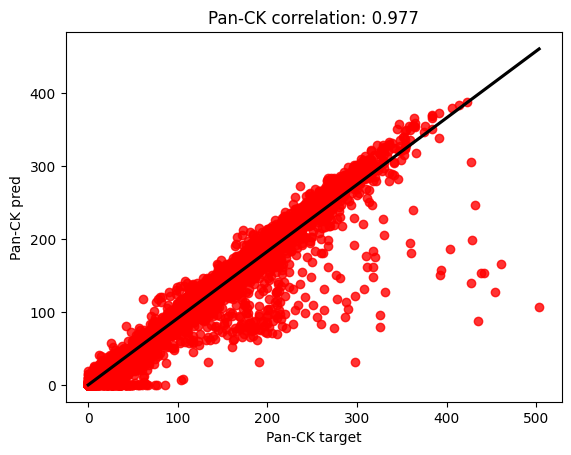

In [48]:
marker_name = "Pan-CK"

corr, _ = pearsonr(tile_sums[f"{marker_name}_pos"], tile_sums[f"{marker_name}_pred_logreg"])
print(corr)

sns.regplot(x=tile_sums[f"{marker_name}_pos"], y=tile_sums[f"{marker_name}_pred_logreg"],
            line_kws={'color': 'black'}, color='red', ci=None)
#plt.xscale("log")
#plt.yscale("log")
plt.title(f'{marker_name} correlation: {round(corr, 3)}')
plt.xlabel(f'{marker_name} target')
plt.ylabel(f'{marker_name} pred')
plt.show()


0.617753396256313


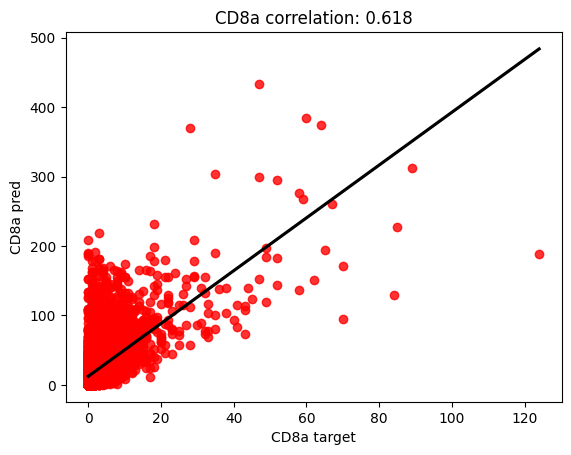

In [49]:
marker_name = "CD8a"

corr, _ = pearsonr(tile_sums[f"{marker_name}_pos"], tile_sums[f"{marker_name}_pred_logreg"])
print(corr)

sns.regplot(x=tile_sums[f"{marker_name}_pos"], y=tile_sums[f"{marker_name}_pred_logreg"],
            line_kws={'color': 'black'}, color='red', ci=None)
#plt.xscale("log")
#plt.yscale("log")
plt.title(f'{marker_name} correlation: {round(corr, 3)}')
plt.xlabel(f'{marker_name} target')
plt.ylabel(f'{marker_name} pred')
plt.show()


In [ ]:
#tile_sums.to_csv("/root/workdir/tmp_tile_sums_orion.csv", index=False)

In [ ]:
#tile_sums = pd.read_csv("/root/workdir/tmp_tile_sums_orion.csv")

In [152]:
# criterion to select top tiles with more than 5 positive cells and orderded by f1 metric per tile

marker_selected = ["CD3e_pos", "FOXP3_pos"]
marker_names = [col.replace("_pos", "") for col in marker_selected]
marker_selected_f1 = [f"{col}_f1" for col in marker_selected]
idxs_channels = [cfg.data.targ_channel_names.index(col.replace("_pos", "")) for col in marker_selected]


idxs_sort = tile_sums[(tile_sums[marker_selected] > 5).all(axis=1)][marker_selected_f1].mean(axis=1).sort_values().index[::-1]
tile_names_sorted = tile_sums["tile_name"].loc[idxs_sort]

In [153]:
from PIL import Image, ImageEnhance
def improve_contrast_image(image):
    enhancer = ImageEnhance.Contrast(Image.fromarray(image))
    contrast_image = np.asarray(enhancer.enhance(2.0))
    return contrast_image

In [154]:
import pyvips
import cv2
test_dataframe["tile_name"] = test_dataframe["image_path"].apply(lambda x: Path(x).stem)

Text(0.5, 1.0, 'Nuclei')

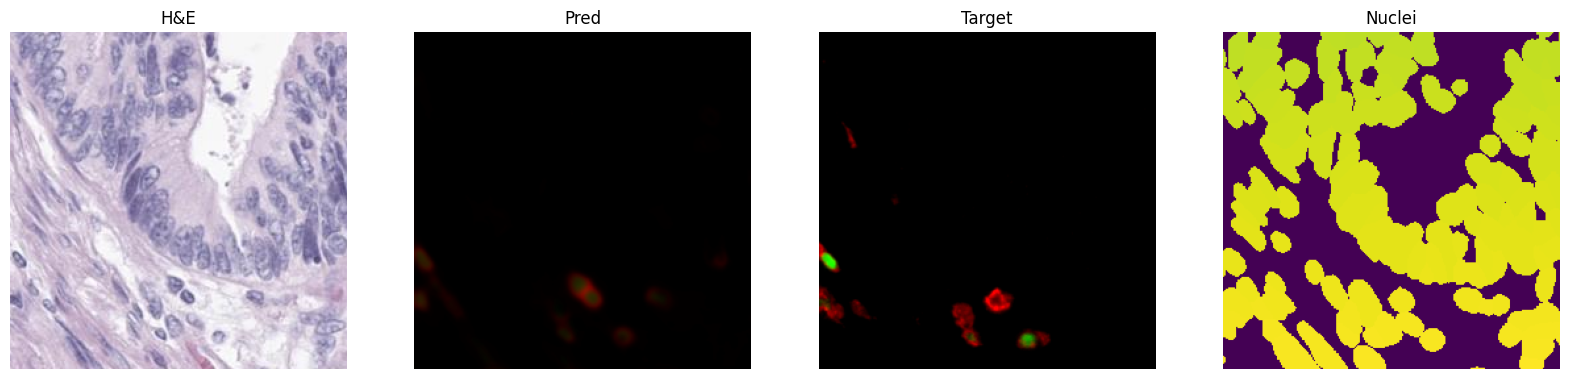

In [156]:
idx_tile = 10

tile_name = tile_names_sorted.iloc[idx_tile]

row_tile = test_dataframe[test_dataframe["tile_name"] == tile_name].iloc[0]

tile_he = cv2.cvtColor(cv2.imread(row_tile["image_path"]), cv2.COLOR_BGR2RGB)
tile_if = pyvips.Image.new_from_file(row_tile["target_path"]).numpy()[..., idxs_channels]
nuclei = cv2.imread(row_tile["nuclei_path"], cv2.IMREAD_ANYDEPTH)

central_crop = A.CenterCrop(256, 256)
tile_he = central_crop(image=tile_he)["image"]
tile_if = central_crop(image=tile_if)["image"]
nuclei = central_crop(image=nuclei)["image"]


x = torch.from_numpy(preprocess_input_fn(tile_he)).permute((2, 0, 1)).unsqueeze(dim=0).cuda()

with torch.inference_mode():
    out = generator(x.half()).float()
    out = (out.clamp(-0.9, 0.9) + 0.9) / 1.8
    out = np.uint8(out[0].cpu().permute((1, 2, 0)).numpy() * 255)

out = out[..., idxs_channels]
out = np.dstack((out, np.zeros_like(out[..., 0])))
tile_if = np.dstack((tile_if, np.zeros_like(tile_if[..., 0])))
#norm_scale = np.percentile(tile_if, 99, axis=(0, 1), keepdims=True) / np.percentile(out, 99, axis=(0, 1), keepdims=True)
#out_scale = np.uint8(np.clip(np.float32(out * norm_scale), 0., 255))

tile_if = improve_contrast_image(tile_if)
out_scale = improve_contrast_image(out)


fig, axis = plt.subplots(1, 4, figsize=(20, 20))
axis[0].imshow(tile_he)
axis[0].axis('off')
axis[0].set_title('H&E')

axis[1].imshow(out_scale)
axis[1].axis('off')
axis[1].set_title('Pred')

axis[2].imshow(tile_if)
axis[2].axis('off')
axis[2].set_title('Target')

axis[3].imshow(nuclei)
axis[3].axis('off')
axis[3].set_title('Nuclei')


In [ ]:
"""cell_metrics = CellMetrics(slide_dataframe, marker_names=cfg.data.targ_channel_names, min_area=20)
x = torch.from_numpy(preprocess_input_fn(tile_he)).permute((2, 0, 1)).unsqueeze(dim=0).cuda()
with torch.inference_mode():
    pred = generator(x.half()).cpu().float()
    cell_metrics.update(pred, torch.from_numpy(nuclei).unsqueeze(0), [row_tile["in_slide_name"]])


test_cell_dataframe = cell_metrics.get_dataframe_cell_pred_target()
test_cell_dataframe["tile_name"] = tile_name

columns_preds = [f"{col}_xgboost_pred" for col in cell_metrics.marker_cols]

n_marker = len(cell_metrics.marker_cols)
logreg = torch.nn.Linear(n_marker, n_marker)
logreg_state_dict = torch.load(str(Path(checkpoint_dir) / "logreg.pth"), map_location="cpu")
logreg.load_state_dict(logreg_state_dict)
logreg.eval()

with torch.inference_mode():
    cell_probs = torch.sigmoid(logreg(torch.from_numpy(test_cell_dataframe[cell_metrics.marker_pred_cols].values).float())).numpy()
    cell_preds = cell_probs > 0.5

test_cell_dataframe[columns_preds] = cell_preds

cell_metrics.reset()"""

In [ ]:
"""cell_metrics = CellMetrics(slide_dataframe, marker_names=cfg.data.targ_channel_names, min_area=20)
x = torch.from_numpy(preprocess_input_fn(tile_he)).permute((2, 0, 1)).unsqueeze(dim=0).cuda()
with torch.inference_mode():
    pred = generator(x.half()).cpu().float()
    cell_metrics.update(pred, torch.from_numpy(nuclei).unsqueeze(0), [row_tile["in_slide_name"]])


test_cell_dataframe = cell_metrics.get_dataframe_cell_pred_target()
test_cell_dataframe["tile_name"] = tile_name

columns_preds = [f"{col}_xgboost_pred" for col in cell_metrics.marker_cols]

with torch.inference_mode():
    cell_logits = logreg(torch.from_numpy(test_cell_dataframe[cell_metrics.marker_pred_cols].values).float())
    cell_preds = torch.sigmoid(cell_logits) > 0.5
    cell_preds = cell_preds.numpy()

test_cell_dataframe[columns_preds] = cell_preds

cell_metrics.reset()"""

NameError: name 'slide_dataframe' is not defined

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

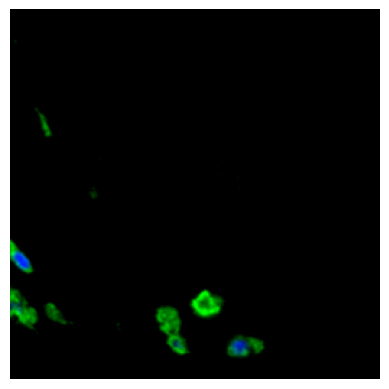

In [157]:
from skimage.exposure import equalize_adapthist

tile_if_contrast = np.zeros_like(out)
tile_if_contrast[..., 1] = np.uint8(equalize_adapthist(tile_if[..., 0])*255)
tile_if_contrast[..., 2] = np.uint8(equalize_adapthist(tile_if[..., 1])*255)
plt.imshow(tile_if_contrast)
plt.axis('off')

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

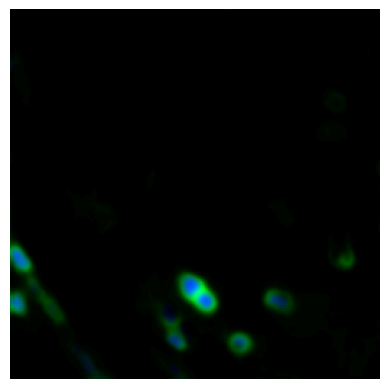

In [158]:
from skimage.exposure import equalize_adapthist

out_contrast = np.zeros_like(out)
out_contrast[..., 1] = np.uint8(equalize_adapthist(out[..., 0])*255)
out_contrast[..., 2] = np.uint8(equalize_adapthist(out[..., 1])*255)
plt.imshow(out_contrast)
plt.axis('off')

In [159]:
cell_dataframe_roi = test_cell_dataframe[test_cell_dataframe["tile_name"] == tile_name]


mask_pred_cd8 = np.isin(nuclei, cell_dataframe_roi[cell_dataframe_roi[f"{marker_names[1]}_pred_logreg"]]["label"].values)
nuclei_pred_cd8 = np.where(mask_pred_cd8, nuclei, 0)
mask_pred_cd3 =  np.isin(nuclei, cell_dataframe_roi[cell_dataframe_roi[f"{marker_names[0]}_pred_logreg"]]["label"].values)
nuclei_pred_cd3 = np.where(mask_pred_cd3, nuclei, 0)
mask_pos_cd8 = np.isin(nuclei, cell_dataframe_roi[cell_dataframe_roi[f"{marker_names[1]}_pos"]]["label"].values)
nuclei_pos_cd8 = np.where(mask_pos_cd8, nuclei, 0)
mask_pos_cd3 = np.isin(nuclei, cell_dataframe_roi[cell_dataframe_roi[f"{marker_names[0]}_pos"]]["label"].values)
nuclei_pos_cd3 = np.where(mask_pos_cd3, nuclei, 0)

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

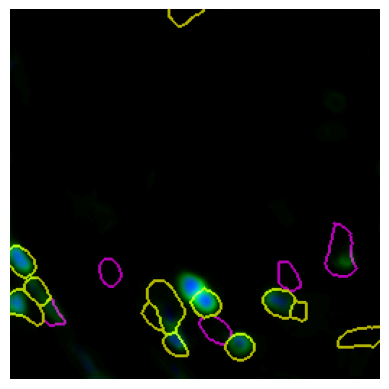

In [160]:
from skimage.segmentation import find_boundaries
from skimage.morphology import binary_dilation, disk


image_vis_pred = out_contrast.copy()

contour_cd8 = find_boundaries(nuclei_pred_cd8, mode='thick')
#contour_cd8 = binary_dilation(contour_cd8, disk(1))
contour_cd3 = find_boundaries(nuclei_pred_cd3, mode='thick')
#contour_cd3 = binary_dilation(contour_cd3, disk(1))
contour = np.zeros_like(image_vis_pred)
contour[contour_cd3] = [255, 0, 255]
contour[contour_cd8] = [255, 255, 0]

image_vis_pred = cv2.addWeighted(image_vis_pred, 1, contour, 0.7, 0)

plt.imshow(image_vis_pred)
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

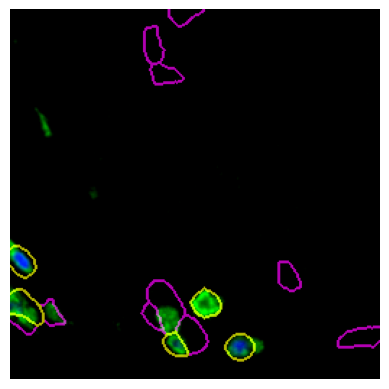

In [161]:
image_vis_target = tile_if_contrast.copy()

contour_cd8 = find_boundaries(nuclei_pos_cd8, mode='thick')
#contour_cd8 = binary_dilation(contour_cd8, disk(1))
contour_cd3 = find_boundaries(nuclei_pos_cd3, mode='thick')
#contour_cd3 = binary_dilation(contour_cd3, disk(1))
contour = np.zeros_like(image_vis_target)
contour[contour_cd3] = [255, 0, 255]
contour[contour_cd8] = [255, 255, 0]

image_vis_target = cv2.addWeighted(image_vis_target, 1, contour, 0.70, 0)

plt.imshow(image_vis_target)
plt.axis("off")

In [119]:
cv2.imwrite("/root/workdir/figure/tile_orion_he.png", cv2.cvtColor(tile_he, cv2.COLOR_BGR2RGB))
cv2.imwrite("/root/workdir/figure/tile_orion_pred.png", cv2.cvtColor(image_vis_pred, cv2.COLOR_BGR2RGB))
cv2.imwrite("/root/workdir/figure/tile_orion_target.png", cv2.cvtColor(image_vis_target, cv2.COLOR_BGR2RGB))

True

## Inference pipeline images

In [53]:
import matplotlib.cm as cm

def mif_to_rgb(mif_image, cmap_name="tab10"):
    """
    Convert a multi-channel uint8 mIF image to an RGB image using a default colormap.

    Args:
        mif_image (numpy.ndarray): Input mIF image of shape (H, W, C), where C is the number of channels.
        cmap_name (str): Name of the colormap from matplotlib.

    Returns:
        numpy.ndarray: RGB image of shape (H, W, 3).
    """
    assert mif_image.dtype == np.uint8, "Input image must be uint8"

    # Get colormap from matplotlib and generate color palette
    cmap = cm.get_cmap(cmap_name, mif_image.shape[2])  # Get N colors for N channels
    palette = np.array([cmap(i)[:3] for i in range(mif_image.shape[2])])  # RGB colors in 0-1 range

    # Initialize the RGB image
    rgb_image = np.zeros((*mif_image.shape[:2], 3), dtype=np.float32)

    # Apply each channel using the colormap
    for channel_idx in range(mif_image.shape[2]):
        for i in range(3):  # RGB channels
            rgb_image[..., i] += (mif_image[..., channel_idx] / 255.0) * palette[channel_idx, i]

    # Normalize and convert to uint8
    rgb_image = np.clip(rgb_image * 255, 0, 255).astype(np.uint8)

    return rgb_image

In [59]:
row_tile = test_dataframe.sample(1).iloc[0]

tile_he = cv2.cvtColor(cv2.imread(row_tile["image_path"]), cv2.COLOR_BGR2RGB)
tile_if = pyvips.Image.new_from_file(row_tile["target_path"]).numpy()[..., idxs_channels]
nuclei = cv2.imread(row_tile["nuclei_path"], cv2.IMREAD_ANYDEPTH)

central_crop = A.CenterCrop(256, 256)
tile_he = central_crop(image=tile_he)["image"]
tile_if = central_crop(image=tile_if)["image"]
nuclei = central_crop(image=nuclei)["image"]


x = torch.from_numpy(preprocess_input_fn(tile_he)).permute((2, 0, 1)).unsqueeze(dim=0).cuda()

with torch.inference_mode():
    out = generator(x.half()).float()
    out = (out.clamp(-0.9, 0.9) + 0.9) / 1.8
    out = np.uint8(out[0].cpu().permute((1, 2, 0)).numpy() * 255)

/tmp/ipykernel_7066/1760078248.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, mif_image.shape[2])  # Get N colors for N channels


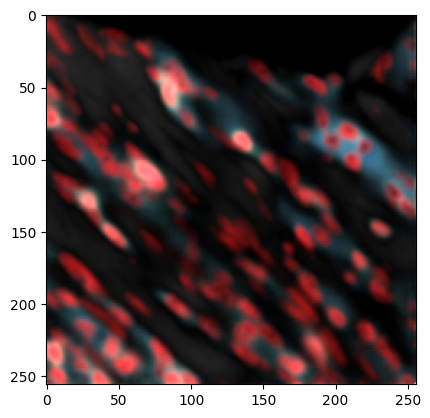

In [60]:
from skimage.exposure import equalize_adapthist

out_contrast = np.zeros_like(out)
for idx_channel in range(out_contrast.shape[-1]):
    out_contrast[..., idx_channel] = improve_contrast_image(out[..., idx_channel])

out_contrast_rgb = mif_to_rgb(out_contrast, cmap_name="Set1")
plt.imshow(out_contrast_rgb)

In [61]:
cell_metrics = CellMetrics(slide_dataframe, marker_names=cfg.data.targ_channel_names, min_area=20)
x = torch.from_numpy(preprocess_input_fn(tile_he)).permute((2, 0, 1)).unsqueeze(dim=0).cuda()
with torch.inference_mode():
    pred = generator(x.half()).cpu().float()
    cell_metrics.update(pred, torch.from_numpy(nuclei).unsqueeze(0), [row_tile["in_slide_name"]])


test_cell_dataframe = cell_metrics.get_dataframe_cell_pred_target()
test_cell_dataframe["tile_name"] = tile_name

columns_preds = [f"{col}_xgboost_pred" for col in cell_metrics.marker_cols]

with torch.inference_mode():
    cell_logits = logreg(torch.from_numpy(test_cell_dataframe[cell_metrics.marker_pred_cols].values).float())
    cell_preds = torch.sigmoid(cell_logits) > 0.5
    cell_preds = cell_preds.numpy()

test_cell_dataframe[columns_preds] = cell_preds

cell_metrics.reset()

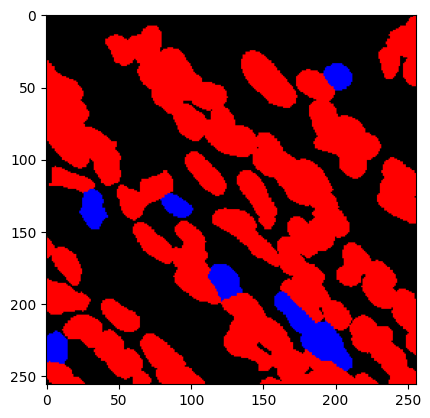

In [69]:
from skimage.color import label2rgb

cell_dataframe_roi = test_cell_dataframe[test_cell_dataframe["tile_name"] == tile_name]

mask_nuclei = np.zeros_like(nuclei, dtype=np.int32)

mask_pred_cd3 =  np.isin(nuclei, cell_dataframe_roi[cell_dataframe_roi["CD3e_pos"]]["label"].values)
mask_nuclei[mask_pred_cd3] = 2

mask_pred_panck =  np.isin(nuclei, cell_dataframe_roi[cell_dataframe_roi["Pan-CK_pos"]]["label"].values)
mask_nuclei[mask_pred_panck] = 1

plt.imshow(label2rgb(mask_nuclei))

In [ ]:
from skimage.exposure import equalize_adapthist

out_contrast = np.zeros_like(out)
for idx_channel in range(out_contrast.shape[-1]):
    out_contrast[..., idx_channel] = improve_contrast_image(out[..., idx_channel])

out_contrast_rgb = mif_to_rgb(out_contrast, cmap_name="Set1")
plt.imshow(out_contrast_rgb)

/tmp/ipykernel_7066/1760078248.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, mif_image.shape[2])  # Get N colors for N channels


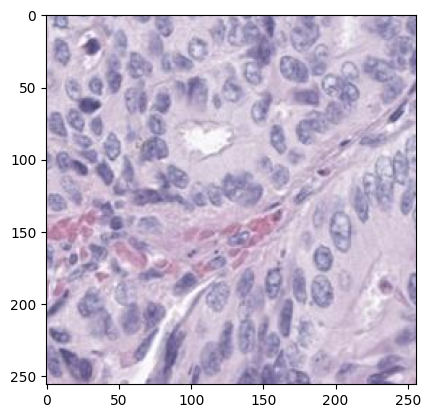

In [55]:
plt.imshow(tile_he)

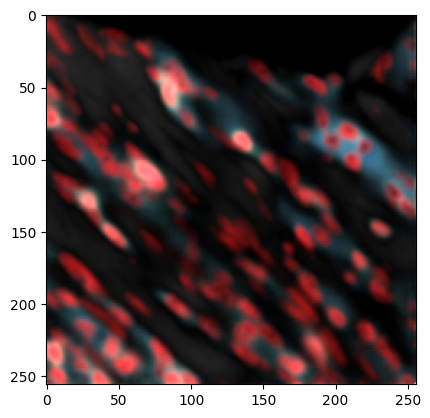

In [70]:
plt.imshow(out_contrast_rgb)

In [79]:
cv2.imwrite("/root/workdir/figure/tile_orion_he_pipeline.png", cv2.cvtColor(tile_he, cv2.COLOR_BGR2RGB))
cv2.imwrite("/root/workdir/figure/tile_orion_pred_pipeline.png", cv2.cvtColor(out_contrast_rgb, cv2.COLOR_BGR2RGB))
cv2.imwrite("/root/workdir/figure/tile_orion_nuclei_pos_pipeline.png", cv2.cvtColor(np.uint8(label2rgb(mask_nuclei) * 255), cv2.COLOR_BGR2RGB))
cv2.imwrite("/root/workdir/figure/tile_orion_nuclei_pipeline.png", cv2.cvtColor(np.uint8(label2rgb(nuclei) * 255), cv2.COLOR_BGR2RGB))

True

## Other

In [25]:
#cell_metrics = CellMetrics(slide_dataframe, marker_names=cfg.data.targ_channel_names, min_area=20)
test_dataframe = pd.read_csv(cfg.data.test_dataframe_path)
test_cell_dataframe_target  = cell_metrics.get_dataframe_cell_target(test_dataframe["in_slide_name"].unique())

In [26]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, f1_score

marker_cols = [col for col in test_cell_dataframe_target.columns if "_pos" in col]

results_random = []
for marker_col in tqdm(marker_cols):
    target_marker = test_cell_dataframe_target[marker_col].values
    marker_prob = target_marker.mean()
    f1_scores = []
    for _  in range(100):
        random_pred = np.random.uniform(size=len(target_marker)) < marker_prob
        f1_scores.append(f1_score(y_true=target_marker, y_pred=random_pred))
    f1_scores = np.asarray(f1_scores)
    results_random.append([marker_col, f1_scores.mean(), f1_scores.std()])

results_random_df = pd.DataFrame(results_random, columns=["Marker name", "F1 mean", "F1 std"])
results_random_df

100%|██████████| 15/15 [03:43<00:00, 14.88s/it]


,Marker name,F1 mean,F1 std
0,CD31_pos,0.043910,0.000666
1,CD45_pos,0.231882,0.000548
2,CD68_pos,0.071708,0.000661
3,CD4_pos,0.124282,0.000683
4,FOXP3_pos,0.014564,0.000827
5,CD8a_pos,0.027182,0.000816
6,CD45RO_pos,0.059879,0.000767
7,CD20_pos,0.026993,0.000651
8,PD-L1_pos,0.010753,0.000850
9,CD3e_pos,0.124185,0.000745


In [27]:
results_random_df.to_csv("/root/workdir/orion_random.csv", index=False)

In [53]:
col = "Ki67_pos"
prob = round(test_cell_dataframe_target[col].mean(), 4)
1 - prob, prob

(0.8806, 0.1194)

In [ ]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

slide_dataframe = pd.read_csv("/root/workdir/data/slide_dataframe.csv")

In [3]:
marker_names = [
    "Hoechst", "CD31", "CD45", "CD68", "CD4", "FOXP3", "CD8a", "CD45RO",
    "CD20", "PD-L1", "CD3e", "CD163", "E-cadherin", "PD-1", "Ki67",
    "Pan-CK", "SMA"
]

slide_dataframe["nuclei_csv_path_expression"] = slide_dataframe["nuclei_csv_path"].apply(lambda x: str(Path("/root/workdir/orion_csv_clean_nuclei") / Path(x).stem.replace(".tiff", ".csv")))
slide_dataframe["nuclei_csv_path_expression"].apply(lambda x: Path(x).exists()).all()

True

In [9]:
cols_float = [str(idx) for idx in range(17)]

df_all = []
for _, row in tqdm(slide_dataframe.iterrows(), total=len(slide_dataframe)):
    df_slide = pd.read_csv(row["nuclei_csv_path_expression"])
    df_slide[cols_float] = df_slide[cols_float].astype(np.float32)
    df_slide["X_centroid"] = df_slide["X_centroid"].astype(np.int32)
    df_slide["Y_centroid"] = df_slide["Y_centroid"].astype(np.int32)
    df_slide["in_slide_name"] = [row["in_slide_name"]] * len(df_slide)
    df_slide["in_slide_name"] = df_slide["in_slide_name"].astype("category")
    df_all.append(df_slide)
df_all = pd.concat(df_all, ignore_index=True)

  0%|          | 0/41 [00:50<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import pandas as pd
from slidevips import SlideVips
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt

slide_dataframe = pd.read_csv("/root/workdir/data/slide_dataframe.csv")


usecols = ["in_slide_name", "image_path"]
dataframe = pd.concat([
    pd.read_csv("/root/workdir/data/train_dataframe.csv", engine='pyarrow', usecols=usecols),
    pd.read_csv("/root/workdir/data/val_dataframe.csv", engine='pyarrow', usecols=usecols),
    pd.read_csv("/root/workdir/data/test_dataframe.csv", engine='pyarrow', usecols=["in_slide_name", "image_path"])
    ], ignore_index=True)
dataframe["x"] = dataframe["image_path"].apply(lambda x: int(Path(x).stem.split('_')[-5]))
dataframe["y"] = dataframe["image_path"].apply(lambda x: int(Path(x).stem.split('_')[-4]))
dataframe["level"] = dataframe["image_path"].apply(lambda x: int(Path(x).stem.split('_')[-3]))

In [54]:
marker_names = [
    "Hoechst", "CD31", "CD45", "CD68", "CD4", "FOXP3", "CD8a", "CD45RO",
    "CD20", "PD-L1", "CD3e", "CD163", "E-cadherin", "PD-1", "Ki67",
    "Pan-CK", "SMA"
]

In [65]:
row = slide_dataframe.sample(1).iloc[0]
dataframe_slide = dataframe[dataframe["in_slide_name"] == row["in_slide_name"]]
tile_positions = dataframe_slide[["x", "y"]].values
tile_size = (512, 512)

df_csv = pd.read_csv(row["nuclei_csv_path"], engine='pyarrow')

slide = SlideVips(row["targ_slide_path"], mode="IF")

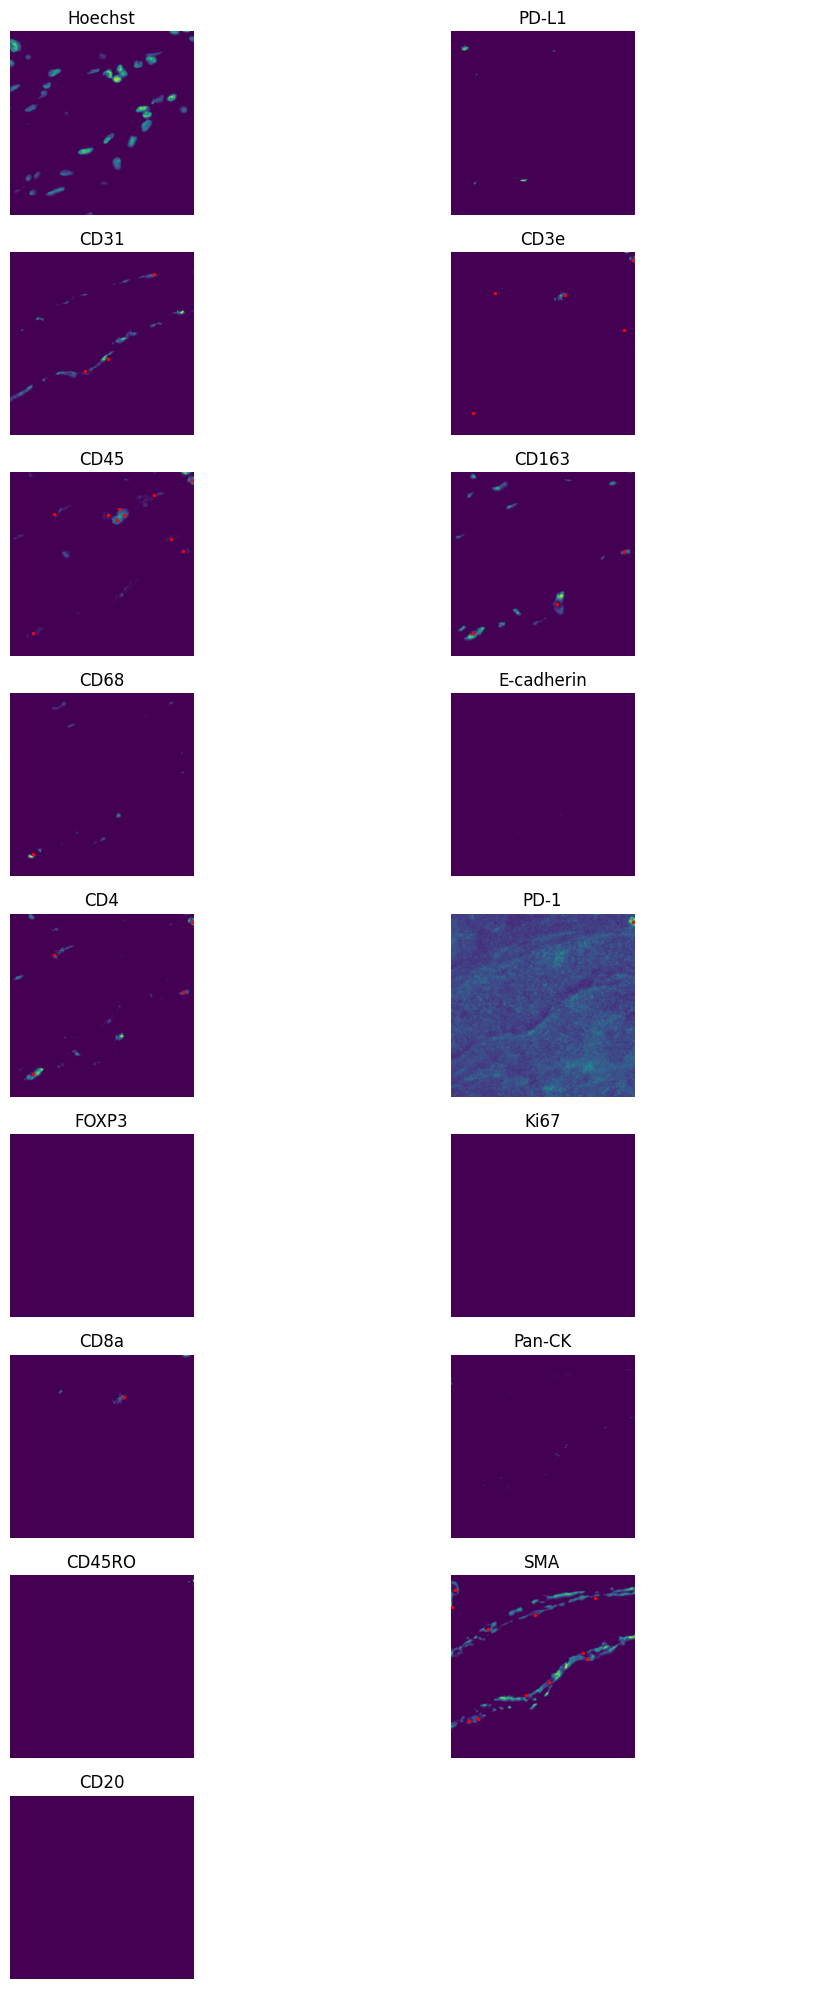

In [78]:
tile_position = tile_positions[np.random.randint(len(tile_positions))]

df_roi_mask = (df_csv["x"].between(tile_position[0], tile_position[0] + tile_size[0])) & (df_csv["y"].between(tile_position[1], tile_position[1] + tile_size[1]))
df_roi = df_csv[df_roi_mask]
centroids = df_roi[["x", "y"]].values - tile_position


tile = slide.read_region(tile_position, 0, (tile_size[0], tile_size[1]))

num_cols = 2  # Fix number of columns to 2
num_rows = (len(marker_names) + num_cols - 1) // num_cols  # Calculate required rows

fig, axis = plt.subplots(num_rows, num_cols, figsize=(10, 20))
axis = axis.T.flatten()

for idx_maker, marker_name in enumerate(marker_names):
    axis[idx_maker].imshow(tile[..., idx_maker])
    axis[idx_maker].set_title(marker_name)
    axis[idx_maker].axis("off")
    if marker_name == "Hoechst":
        continue
    df_roi_marker = df_roi[df_roi[f"{marker_name}_pos"]]
    centroids_marker = df_roi_marker[["x", "y"]].values - tile_position
    axis[idx_maker].scatter(centroids_marker[..., 0], centroids_marker[..., 1], s=2, c="red")


# Hide any unused subplots
for i in range(len(marker_names), len(axis)):
    axis[i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
CD163: to high threshold ??
CD68, some are missed
CD3 to low threshold,
CD20 too low sometimes.
CD31 too low

In [1]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

csv_paths = [str(fn) for fn in Path("/root/workdir/orion_csv_clean_nuclei").glob("*.csv")]
len(csv_paths)

41

In [2]:
df_slide = pd.read_csv(csv_paths[0])

KeyboardInterrupt: 

In [ ]:
pred_cols = [str(idx) for idx in range(17)]

df_all = []
for csv_path in tqdm(csv_paths):
    df_slide = pd.read_csv(csv_path)
    df_slide[pred_cols] = df_slide[pred_cols].astype(np.float16)
    df_slide[['X_centroid', 'Y_centroid']] = df_slide[['X_centroid', 'Y_centroid']].astype(np.int32)
    df_all.append(df_slide)
df_all = pd.concat(df_all, ignore_index=True)

  0%|          | 0/41 [00:00<?, ?it/s]

In [ ]:
from sklearn.mixture import GaussianMixture

def get_threshold_gmm(df_all, marker_name, log_norm=True):
    gmm = GaussianMixture(n_components=2, random_state=42)
    data = df_all[df_all[marker_name] > 0][[marker_name]]
    if log_norm:
        shift_log = 1
        gmm.fit(np.log(data + shift_log))
    else:
        gmm.fit(data)
    means = gmm.means_.flatten()
    variances = gmm.covariances_.flatten()

    # Find the threshold: intersection of two Gaussians
    mean1, mean2 = sorted(means)
    std1, std2 = np.sqrt(sorted(variances))

    threshold = (mean1 * std2**2 - mean2 * std1**2 + std1 * std2 * \
        np.sqrt((mean1 - mean2)**2 + 2 * (std2**2 - std1**2) * np.log(std2 / std1))) / (std2**2 - std1**2)
    if log_norm:
        threshold = (np.exp(threshold) - shift_log)

    plt.hist(data, bins=255, density=True, alpha=0.5, label="Data Distribution")
    plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f"Threshold: {threshold:.2f}")
    plt.legend()
    plt.title("Bi-Gaussian Distribution and Thresholding")
    plt.show()
    return threshold